In [15]:
import io
from PIL import Image
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import json
import torch.utils.data as tdata
from tqdm import tqdm
from torch import optim
import torch.nn as nn

from transformers.models.detr.feature_extraction_detr import rgb_to_id
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [16]:
seed_value = 7
torch.manual_seed(seed_value)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)

In [17]:
device= torch.device("cuda:0")
device

device(type='cuda', index=0)

In [18]:
# # %pip install --upgrade pyarrow
# %pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

In [19]:
from datasets import load_dataset

dataset = load_dataset("keremberke/excavator-detector", "full")

KeyboardInterrupt: 

In [ ]:
#  %pip install -qq -U diffusers datasets transformers accelerate ftfy  pyarrow==15.0.2

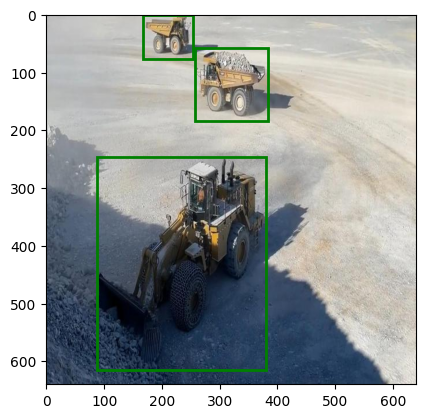

In [ ]:
boxes=dataset['train']['objects'][0]['bbox']


im=dataset['train']['image'][0]

fig, ax = plt.subplots()

ax.imshow(im)

for box in boxes:
    x=box[0]
    y=box[1]
    h=box[2]
    w=box[3]
    ax.add_patch(plt.Rectangle((x,y), h,w, edgecolor='green', facecolor=(0,0,0,0), lw=2))


plt.show()

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
        revision="no_timm",
        num_labels=3,
        ignore_mismatched_sizes=True).to(device)

In [ ]:
dataset['train']['objects']

[{'id': [1001, 1002, 1003],
  'area': [15876, 6530, 108117],
  'bbox': [[257.0, 58.0, 126.0, 126.0],
   [168.0, 0.0, 86.5, 75.5],
   [87.0, 246.0, 293.0, 369.0]],
  'category': [1, 1, 2]},
 {'id': [1645],
  'area': [222202],
  'bbox': [[45.0, 112.0, 533.5, 416.5]],
  'category': [0]},
 {'id': [2423],
  'area': [365205],
  'bbox': [[0.0, 7.0, 627.5, 582.0]],
  'category': [2]},
 {'id': [1587, 1588],
  'area': [389180, 33682],
  'bbox': [[0.0, 0.0, 610.0, 638.0], [504.0, 284.0, 135.0, 249.5]],
  'category': [2, 2]},
 {'id': [3098],
  'area': [108129],
  'bbox': [[148.0, 150.0, 399.0, 271.0]],
  'category': [0]},
 {'id': [1888],
  'area': [69819],
  'bbox': [[57.0, 227.0, 214.5, 325.5]],
  'category': [0]},
 {'id': [823],
  'area': [176144],
  'bbox': [[121.0, 179.0, 446.5, 394.5]],
  'category': [1]},
 {'id': [733],
  'area': [231162],
  'bbox': [[50.0, 38.0, 409.5, 564.5]],
  'category': [2]},
 {'id': [1034, 1035],
  'area': [14193, 30071],
  'bbox': [[55.0, 98.0, 114.0, 124.5], [262.0,

In [ ]:
dataset['train'][0]

{'image_id': 714,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [1001, 1002, 1003],
  'area': [15876, 6530, 108117],
  'bbox': [[257.0, 58.0, 126.0, 126.0],
   [168.0, 0.0, 86.5, 75.5],
   [87.0, 246.0, 293.0, 369.0]],
  'category': [1, 1, 2]}}

In [ ]:
class Dataset(tdata.Dataset):
    def __init__(self,size,dataset,processor):
        self.processor=processor
        self.image=[]
        self.targets=[]
        for id in range(size):
            data=dataset[id]
            self.image.append(data['image'])
            target={"image_id":data['image_id'],"annotations":[]}
            for id in range(len(data['objects']['bbox'])):
                target['annotations'].append({'bbox':data['objects']['bbox'][id],'category_id':data['objects']['category'][id],'area':data['objects']['bbox'][id][2]*data['objects']['bbox'][id][3]})
            self.targets.append(target)
        self.len=size

    def __getitem__(self, id):
        encoded=self.processor(images=self.image[id], annotations=self.targets[id], return_tensors="pt")
        return  encoded["pixel_values"].squeeze().to(device),encoded["labels"][0]

    def __len__(self):
        return self.len



In [ ]:
train_set=Dataset(500,dataset['train'],processor=processor)
val_set=Dataset(266,dataset['validation'],processor=processor)

NameError: name 'processor' is not defined

In [ ]:
def collate_fn(batch):
  pixel_values = [item[0].cpu() for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [ {k:v.to(device) for k,v in item[1].items()}  for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values'].to(device)
  batch['pixel_mask'] = encoding['pixel_mask'].to(device)
  batch['labels'] = labels
  return batch


train_data=tdata.DataLoader(train_set,batch_size=4,collate_fn=collate_fn)
val_data=tdata.DataLoader(val_set,batch_size=2,collate_fn=collate_fn)

In [ ]:
optimizer=optim.Adam(model.parameters(),lr=0.01)

In [ ]:
EPOCH=[]
TLOSS=[]
VLOSS=[]

for epoch in tqdm(range(10)):
    model.train()
    tloss=0
    runs=0
    for batch in train_data:
        optimizer.zero_grad()
        output=model(pixel_values=batch['pixel_values'],pixel_mask =batch['pixel_mask'],labels=batch['labels'])
        loss=output.loss
        loss.backward()
        optimizer.step()
        tloss+=loss.item()
        runs+=1
    TLOSS.append(tloss)

    model.eval()
    tloss=0
    for batch in val_data:
        output=model(pixel_values=batch['pixel_values'],pixel_mask =batch['pixel_mask'],labels=batch['labels'])
        loss=output.loss
        tloss+=loss.item()
    VLOSS.append(tloss)

    EPOCH.append(epoch)


100%|██████████| 10/10 [13:50<00:00, 83.02s/it]


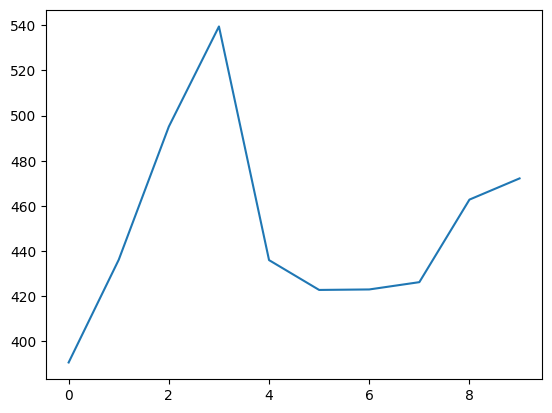

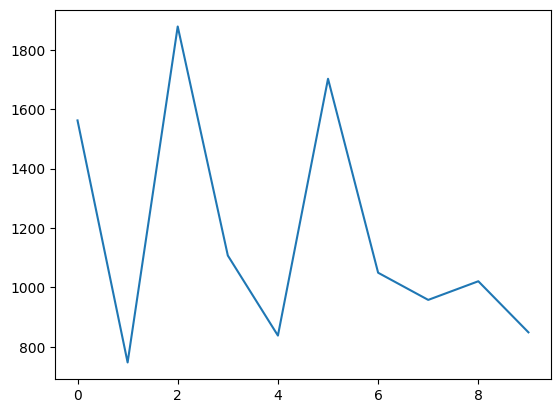

In [ ]:
plt.plot(EPOCH,TLOSS)
plt.show()
plt.plot(EPOCH,VLOSS)
plt.show()

In [ ]:
output=model(processor.pad(train_set[37][0].unsqueeze(0).cpu(), return_tensors="pt")['pixel_values'].to(device))

target_sizes = torch.tensor([train_set.image[1].size[::-1]])
out=processor.post_process(output,target_sizes)


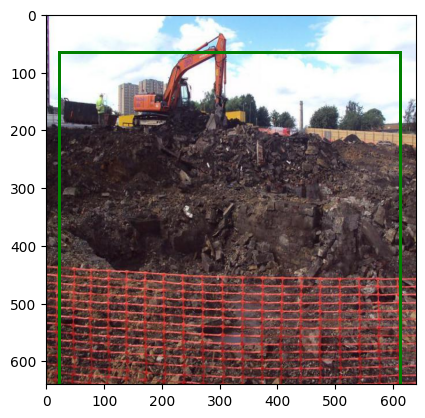

In [ ]:
boxes=out[0]['boxes'][0:].detach().cpu().numpy()


im=train_set.image[37]

fig, ax = plt.subplots()

ax.imshow(im)

for box in boxes:
    x=box[0]
    y=box[1]
    h=box[2]
    w=box[3]
    ax.add_patch(plt.Rectangle((x,y), h,w, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    # break


plt.show()

In [ ]:
out

[{'scores': tensor([0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728, 0.0728,
          0.0728], device='cuda:0', grad_fn=<UnbindBackward0>),
  'labels': tensor([0, 0

In [ ]:
train_set[1][0].unsqueeze(0).shape

torch.Size([1, 3, 800, 800])

In [ ]:
for b in train_data:
  print(b['pixel_values'].shape)
  break

torch.Size([4, 3, 800, 800])
